# Учимся работе с данными - от загрузки до моделирования

# Часть 1. EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

In [2]:
df = pd.read_csv('data.csv')

# Базовые статистики

In [3]:
print(df.describe())
print("Медианы:\n", df.median(numeric_only=True))

                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813     

# Гистограммы признаков, сгруппированные по целевой переменной (diagnosis)

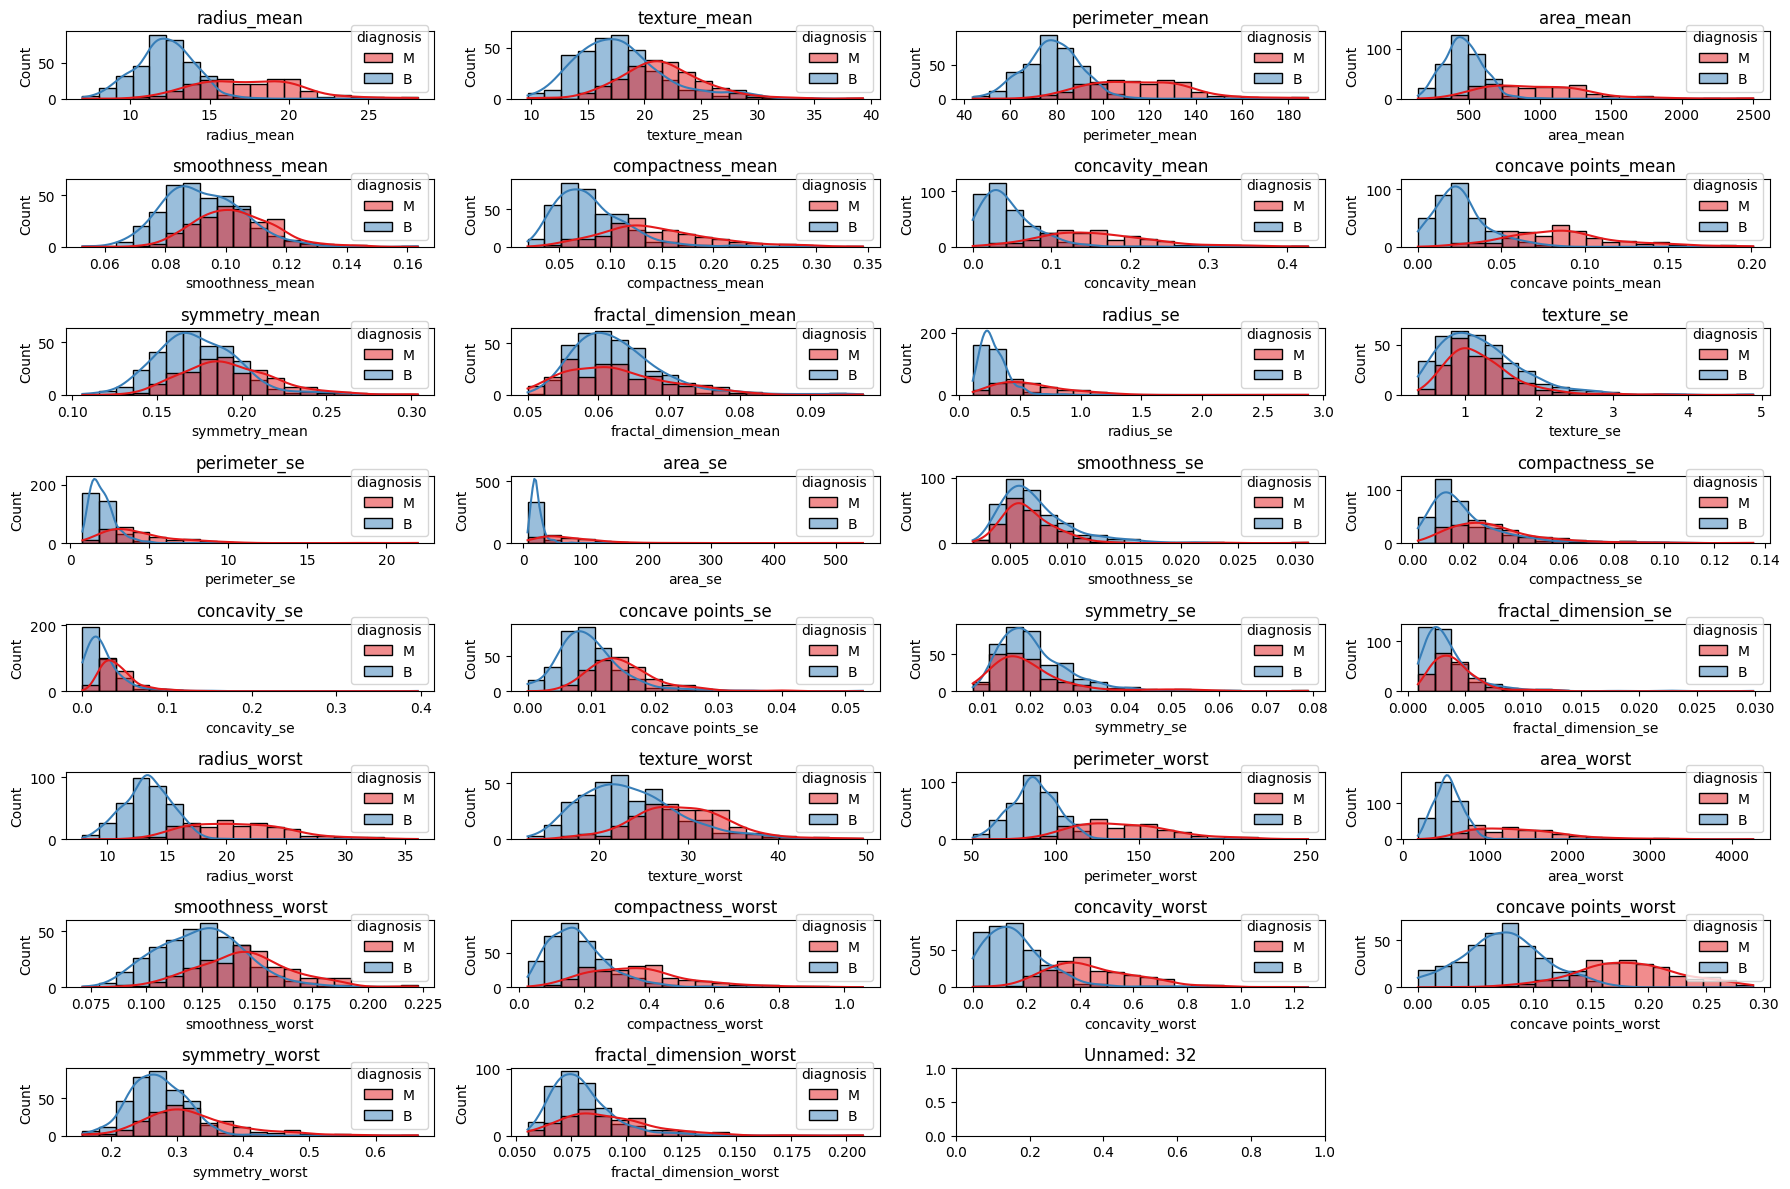

In [ ]:
features = [col for col in df.columns if col not in ['id', 'diagnosis']]
plt.figure(figsize=(18, 12))
for i, col in enumerate(features): 
    plt.subplot(int(-1 * len(features) // 4 * -1), 4, i+1)
    sns.histplot(data=df, x=col, hue='diagnosis', bins=20, kde=True, palette='Set1')
    plt.title(col)
plt.tight_layout()
plt.show()

# Матрица корреляций и heatmap

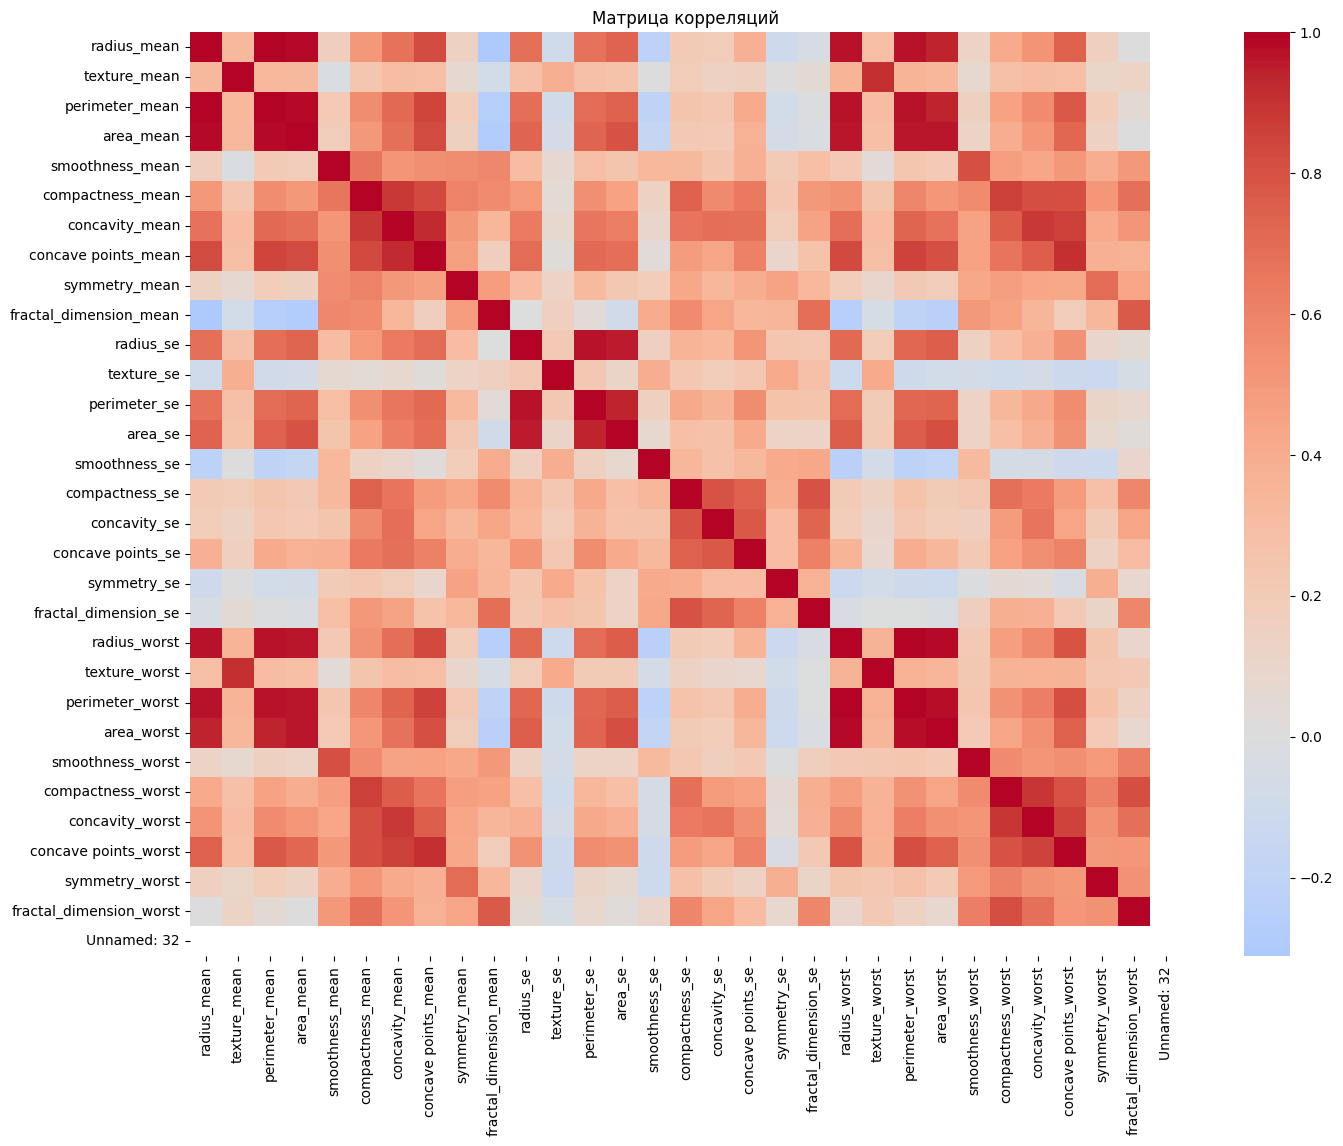

In [17]:
corr = df[features].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

# Сильно скоррелированные признаки (>0.8)

In [18]:
strong_corr = corr.abs().unstack().sort_values(ascending=False)
strong_pairs = [(i, j) for i, j in strong_corr.index if i != j and strong_corr[(i, j)] > 0.8]
print("Сильно скоррелированные признаки:", set(strong_pairs))

Сильно скоррелированные признаки: {('area_mean', 'perimeter_worst'), ('area_se', 'area_worst'), ('perimeter_worst', 'area_mean'), ('area_mean', 'area_worst'), ('perimeter_worst', 'concave points_mean'), ('compactness_se', 'concavity_se'), ('concave points_mean', 'perimeter_worst'), ('area_worst', 'perimeter_mean'), ('concave points_mean', 'area_worst'), ('radius_worst', 'perimeter_mean'), ('compactness_mean', 'concavity_worst'), ('fractal_dimension_se', 'compactness_se'), ('radius_mean', 'perimeter_mean'), ('perimeter_worst', 'area_worst'), ('concave points_mean', 'radius_mean'), ('fractal_dimension_worst', 'compactness_worst'), ('area_mean', 'radius_worst'), ('compactness_mean', 'compactness_worst'), ('concave points_worst', 'compactness_mean'), ('perimeter_se', 'area_se'), ('area_worst', 'radius_worst'), ('compactness_worst', 'fractal_dimension_worst'), ('perimeter_mean', 'radius_worst'), ('area_mean', 'perimeter_mean'), ('concave points_worst', 'concave points_mean'), ('compactness_

# Scatterplot для пары сильно скоррелированных признаков

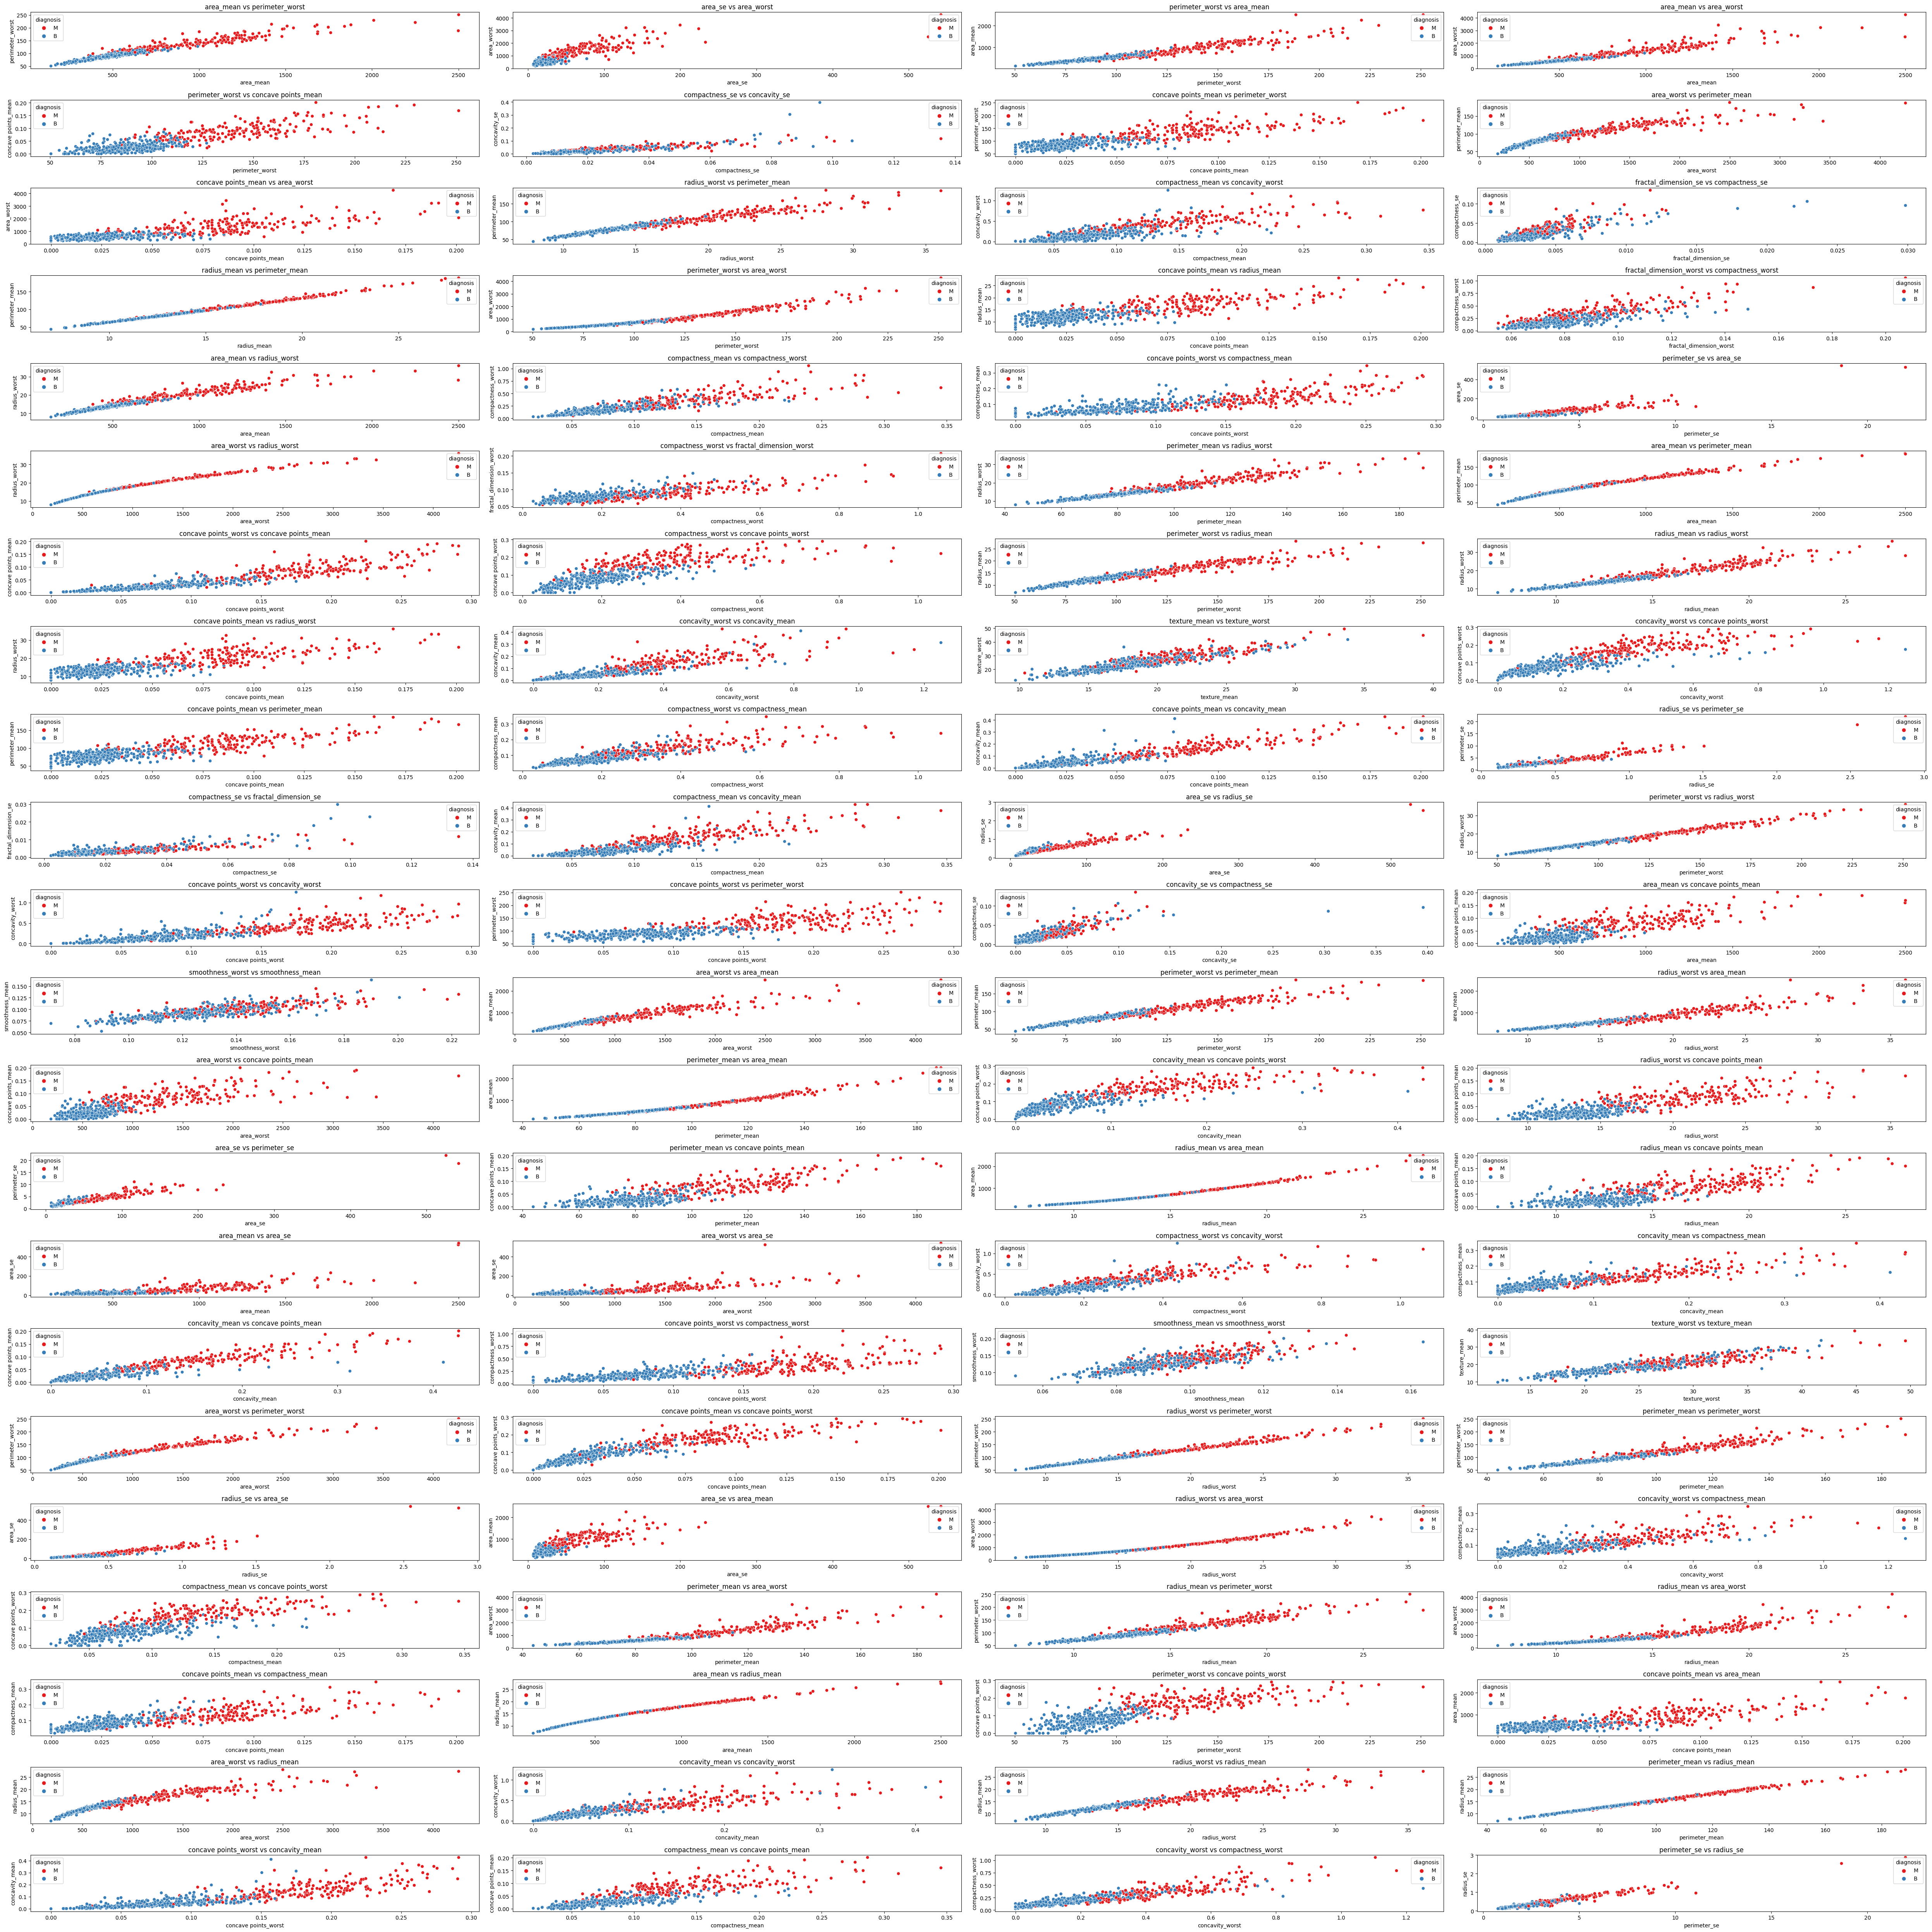

In [30]:
plt.figure(figsize=(50, 50))
for i, (f1, f2) in enumerate(list(set(strong_pairs))):
    plt.subplot(int(-1 * len(list(set(strong_pairs))) // 4 * -1), 4, i+1)
    sns.scatterplot(data=df, x=f1, y=f2, hue='diagnosis', palette='Set1')
    plt.title(f"{f1} vs {f2}")
plt.tight_layout()
plt.show()

# Boxplot для признаков по целевой переменной

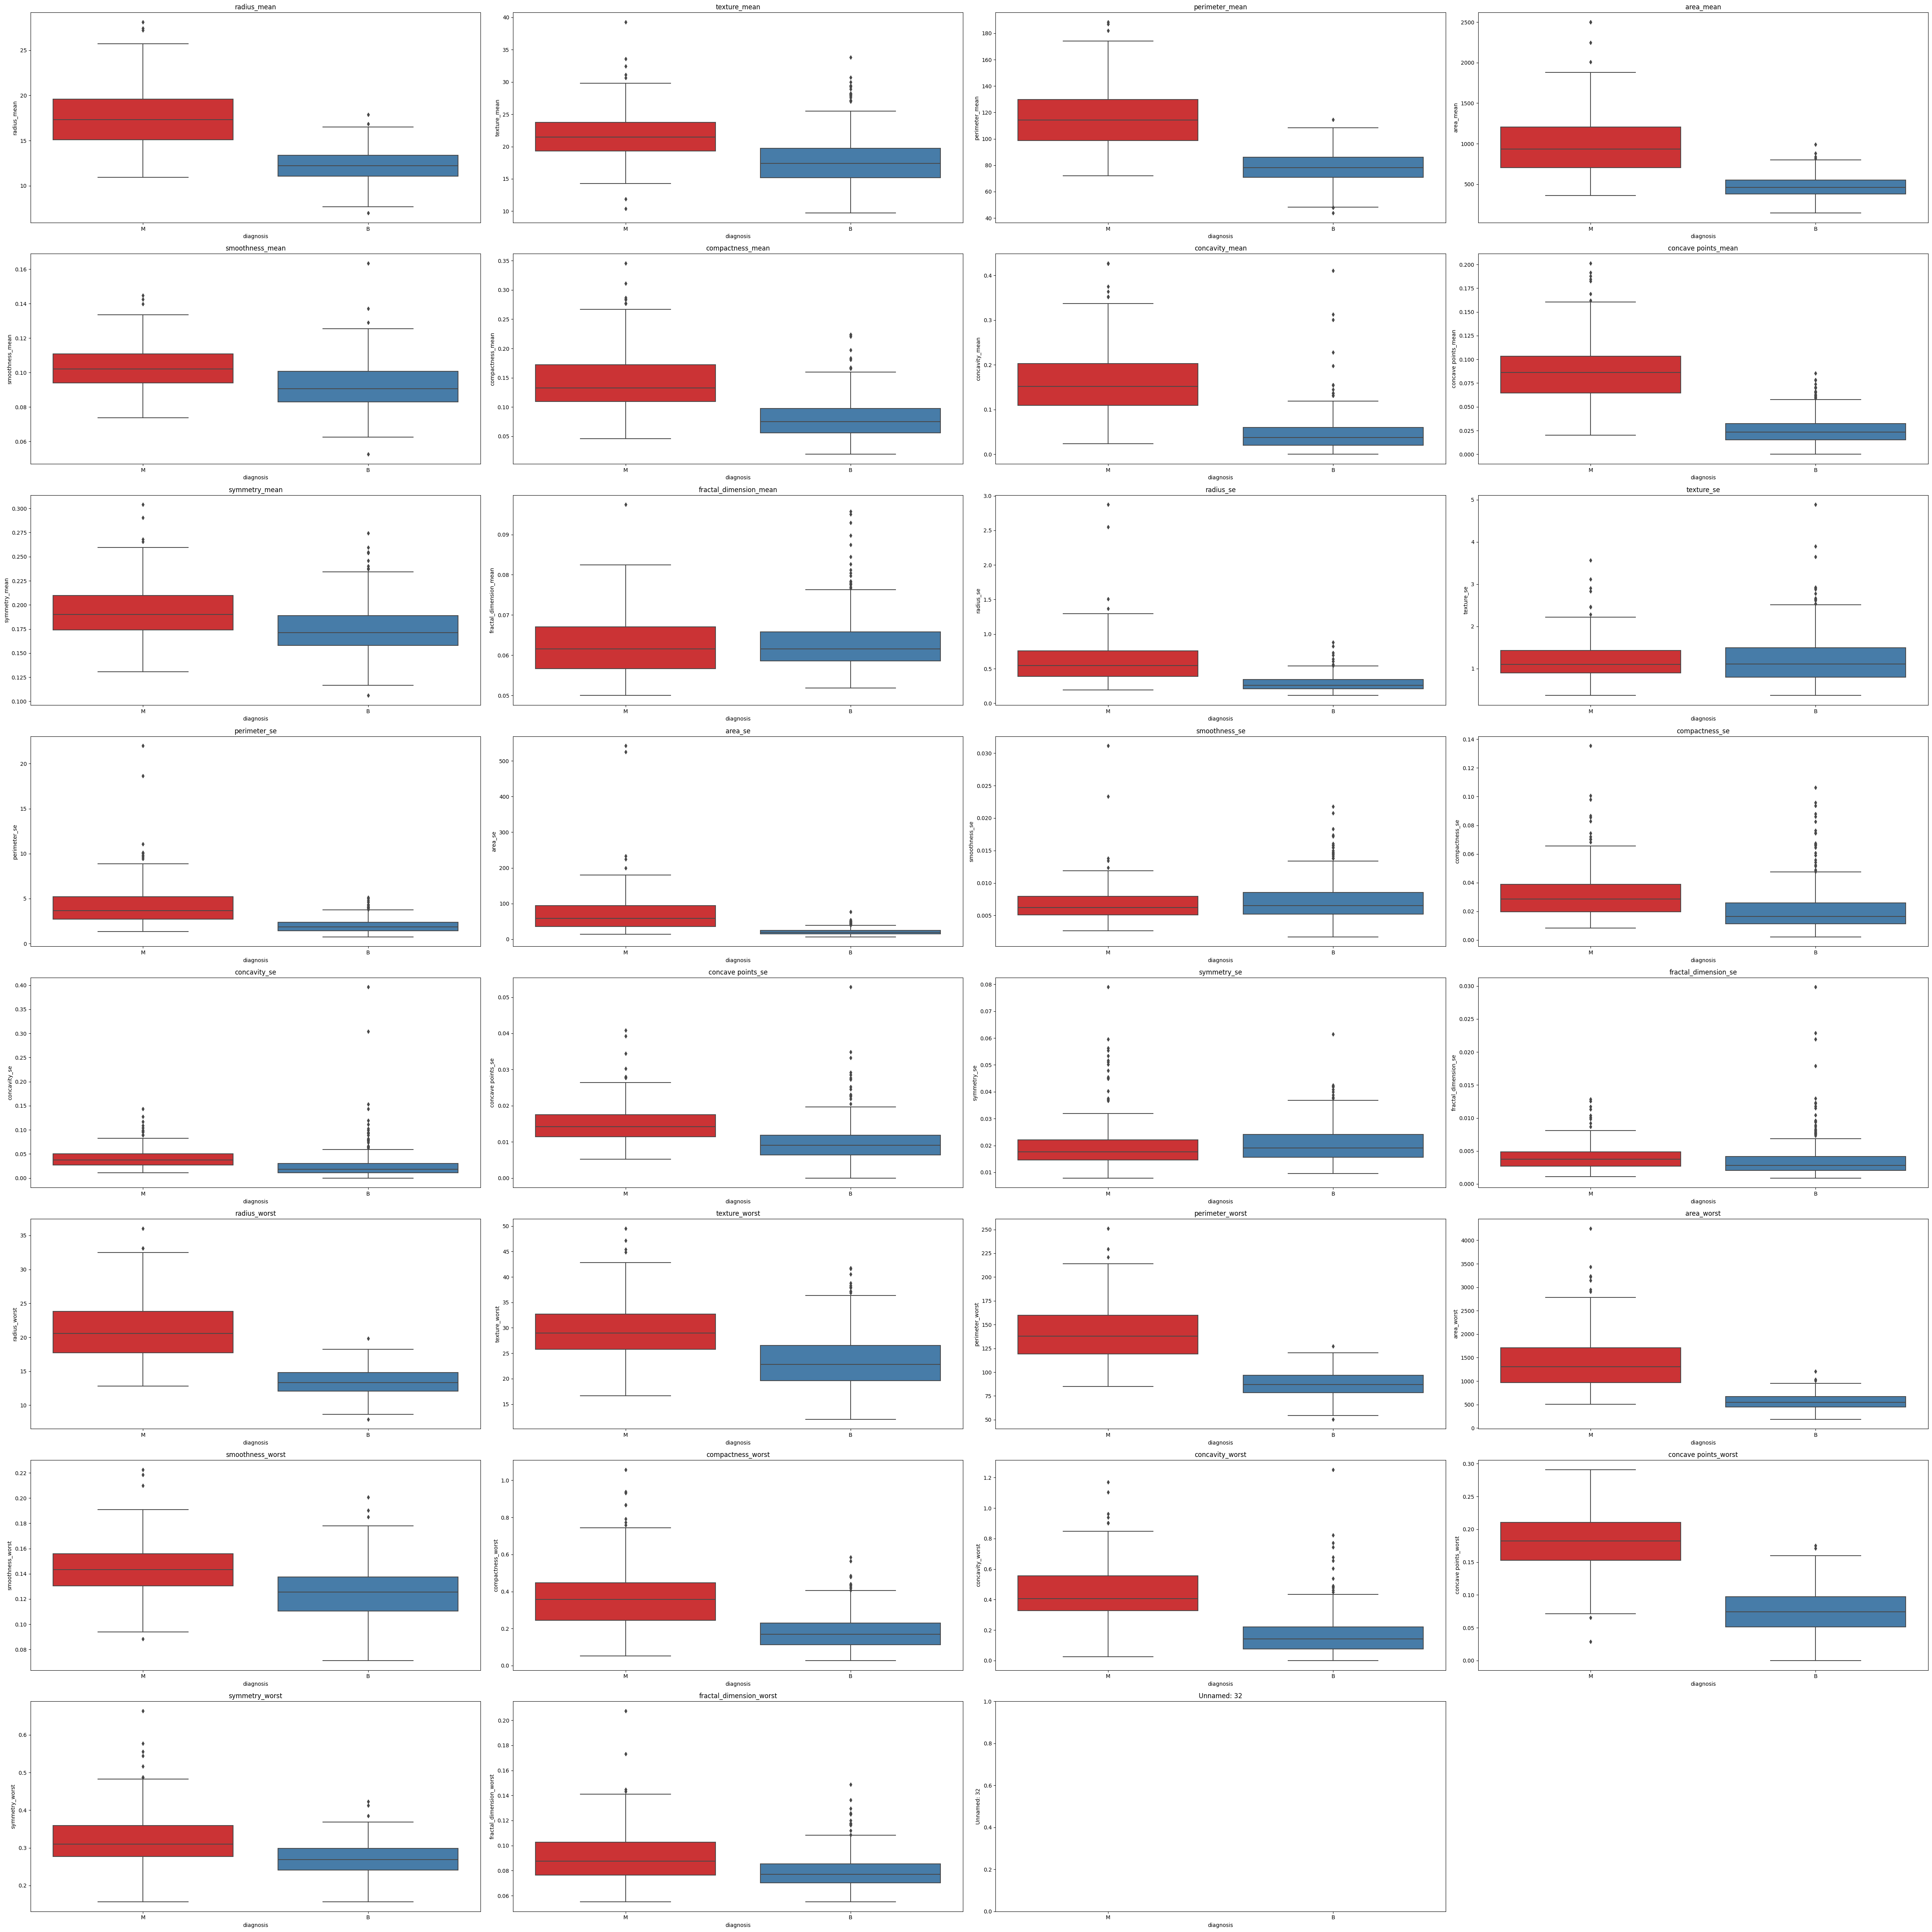

In [31]:
plt.figure(figsize=(50, 50))
for i, col in enumerate(features):
    plt.subplot(int(-1 * len(features) // 4 * -1), 4, i+1)
    #plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, x='diagnosis', y=col, palette='Set1')
    plt.title(col)
plt.tight_layout()
plt.show()

# Все признаки с низкой корреляцией, их scatterplot

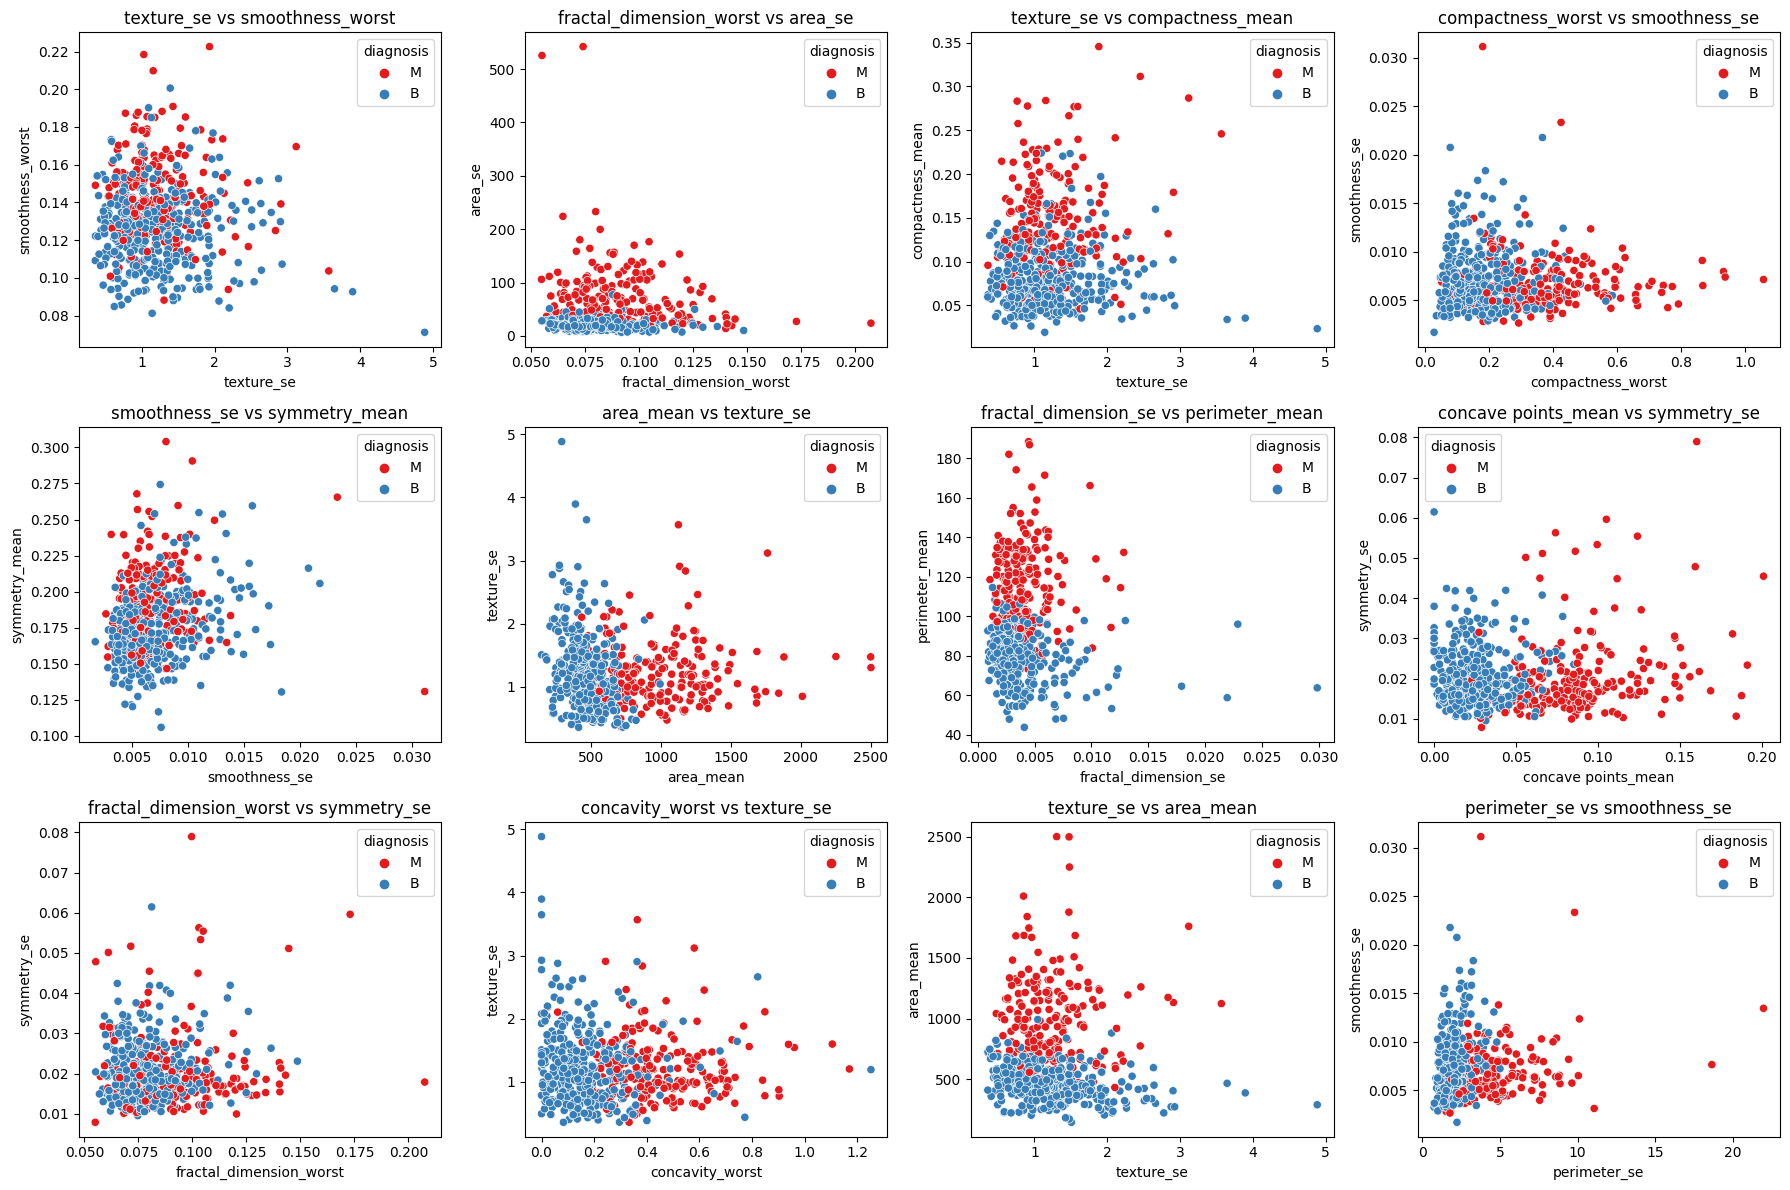

In [34]:
# Соберём пары признаков с низкой корреляцией (< 0.2 по модулю)
low_corr_pairs = [(i, j) for i, j in corr.abs().unstack().index 
                  if i != j and abs(corr.loc[i, j]) < 0.2]

# Визуализация пар признаков с низкой корреляцией (<0.2) в виде scatterplot
plt.figure(figsize=(18, 12))
low_corr_pairs_unique = list(set(low_corr_pairs))[:12]  # ограничим до 12 пар для наглядности
for i, (f1, f2) in enumerate(low_corr_pairs_unique):
    plt.subplot(3, 4, i+1)
    sns.scatterplot(data=df, x=f1, y=f2, hue='diagnosis', palette='Set1')
    plt.title(f"{f1} vs {f2}")
plt.tight_layout()
plt.show()

# Выводы:
# 1. Сильно скоррелированные признаки: например, perimeter_mean и radius_mean, area_mean и radius_mean, perimeter_mean и area_mean.
# 2. Для отделения злокачественных от доброкачественных новообразований хорошо подходят признаки: area_mean, perimeter_mean, radius_mean, concavity_mean, compactness_mean (по boxplot видно, что распределения сильно различаются).

# Часть 2. Моделирование при помощи kNN

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Разделение на train/test

In [67]:
# Если после удаления NaN X стал пустым, значит в исходных данных есть столбцы, полностью состоящие из NaN.
# Нужно удалить такие столбцы перед обучением:

X = df[features].copy()
print("Количество NaN в данных до заполнения:", X.isnull().sum().sum())
X = X.fillna(X.median(numeric_only=True))
print("Количество NaN после заполнения:", X.isnull().sum().sum())

# Удаляем столбцы, где все значения NaN
X = X.dropna(axis=1, how='all')

# Удаляем строки с оставшимися NaN
X = X.dropna()
y = (df.loc[X.index, 'diagnosis'] == 'M').astype(int)

print("Размер данных после очистки:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Количество NaN в данных до заполнения: 569
Количество NaN после заполнения: 569
Размер данных после очистки: (569, 30)


# Стандартизация признаков
# Стандартизация нужна, чтобы все признаки были в одном масштабе, иначе признаки с большими значениями будут доминировать при расчёте расстояний в kNN.

In [68]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Модель kNN

In [69]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
y_proba = knn.predict_proba(X_test_scaled)[:, 1]

# Метрики качества

In [70]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.9590643274853801
Precision: 0.9516129032258065
Recall: 0.9365079365079365
F1-score: 0.944


# ROC-кривая и AUC

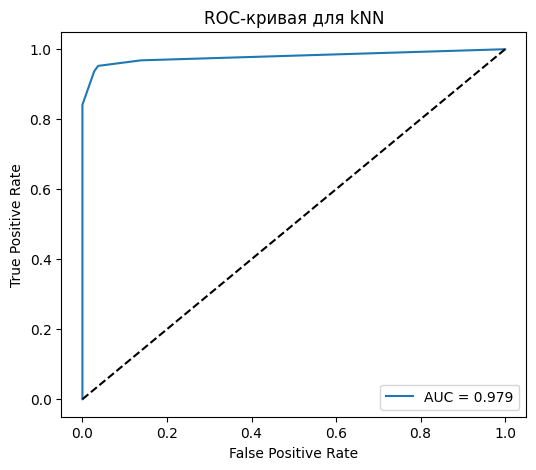

In [71]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для kNN')
plt.legend()
plt.show()

## Основные метрики бинарной классификации

**Accuracy (доля правильных ответов):**
$$
\text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}
$$
Отношение правильно предсказанных наблюдений ко всем наблюдениям. Оптимальна для сбалансированных классов. Применяется для оценки общей доли верных ответов. Может вводить в заблуждение при несбалансированных классах.

---

**Precision (точность):**
$$
\text{Precision} = \frac{TP}{TP + FP}
$$
Доля настоящих положительных среди всех объектов, предсказанных как положительные. Важна для задач, где ложноположительные недопустимы. Важна, когда ложноположительные результаты серьезны (например, медицинская диагностика).

---

**Recall (полнота):**
$$
\text{Recall} = \frac{TP}{TP + FN}
$$
Доля всех истинных положительных, которые удалось найти. Критична, когда важно находить все положительные случаи. Важна, когда критично не пропустить положительный случай (например, поиск мошенничества).

---

**F1-score:**
$$
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$
Гармоническое среднее precision и recall. Наиболее информативна при дисбалансе классов. Используется, когда важен баланс между полнотой и точностью, особенно при несбалансированных классах.

---

**ROC-AUC:**
Площадь под ROC-кривой — обобщённый показатель качества ранжирования вероятностей для задания порога. Ближе к 1 — лучше качество классификации. 0.9...1 = отличное качество, 
0.7...0.8 =  хорошее, < 0.7 — посредственное качество. ROC-AUC ближе к 1 — модель близка к идеальной, ближе к 0.5 — случайное предсказание.

----
Где:
- TP (True Positive) — истинно положительные предсказания 
- TN (True Negative) — истинно отрицательные
- FP (False Positive) — ложноположительные
- FN (False Negative) — ложноотрицательные


# Настройка числа соседей на кросс-валидации

Параметр n_neighbors сильно влияет на качество модели:

Малые значения k (например, 1–3) делают модель чувствительной к шуму и выбросам — переобучение.

Большие значения k сглаживают границы между классами, что может привести к недообучению.

Оптимальное значение k позволяет повысить устойчивость и точность модели.

ПРАКТИКА:

1. Готовится тренировочная выборка (с нормализацией!):

    KNN чувствителен к масштабу признаков, поэтому обычно используют StandardScaler.

2. Выбирается диапазон гиперпараметра:

    Например: k=1,2,…,20.

3. Запускается кросс-валидация для каждого k:

    Для каждого значения k обучается модель и вычисляется средняя метрика (accuracy, f1 и др.) на кросс-валидации.

4. Строится график зависимости метрики от k (опционально).

5. Выбирается значение k с наилучшей средней метрикой.

6. Переобучается финальная модель на оптимальном k на всех тренировочных данных.

In [77]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Подбор k на кросс-валидации
k_range = range(1, 21)
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=20, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = k_range[np.argmax(cv_scores)]
print(f"Оптимальное число соседей: {optimal_k}, точность: {max(cv_scores):.3f}")


Оптимальное число соседей: 4, точность: 0.965


### Можно автоматизировать процесс с помощью GridSearchCV:

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 21)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=20, scoring='accuracy')
grid.fit(X_train_scaled, y_train)
print("Лучшее число соседей:", grid.best_params_['n_neighbors'])
print("Лучшая кросс-валидационная accuracy:", grid.best_score_)

Лучшее число соседей: 4
Лучшая кросс-валидационная accuracy: 0.9646052631578946


# Оценка на тесте с лучшим параметром

In [79]:
best_knn = grid.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)
y_proba_best = best_knn.predict_proba(X_test_scaled)[:, 1]
print("Accuracy (best):", accuracy_score(y_test, y_pred_best))
print("Precision (best):", precision_score(y_test, y_pred_best))
print("Recall (best):", recall_score(y_test, y_pred_best))
print("F1-score (best):", f1_score(y_test, y_pred_best))
print("AUC (best):", roc_auc_score(y_test, y_proba_best))

Accuracy (best): 0.9649122807017544
Precision (best): 0.9672131147540983
Recall (best): 0.9365079365079365
F1-score (best): 0.9516129032258065
AUC (best): 0.9801587301587301


# 3. Бонусное задание для любопытствующих

In [80]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# 1. Удаляем признаки с корреляцией > 0.85

Логистическая регрессия плохо работает с сильно коррелированными (линейно зависимыми) признаками — это вызывает мультиколлинеарность, что приводит к:

Неустойчивости коэффициентов модели;

Плохой интерпретируемости (коэффициенты могут иметь хаотичные знаки и значения);

Повышенной дисперсии оценок параметров.

Чтобы избежать этого, обычно строят матрицу корреляций Пирсона и исключают из пар признаков с корреляцией выше порога 0.85 один признак.

In [81]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
X_lr = X.drop(columns=to_drop)

print("Оставшиеся признаки:", X_lr.shape[1])

Оставшиеся признаки: 17


# 2. Стандартизация

In [82]:
scaler_lr = StandardScaler()
X_train_lr = scaler_lr.fit_transform(X_train[X_lr.columns])
X_test_lr = scaler_lr.transform(X_test[X_lr.columns])

# 3. Логистическая регрессия "из коробки"

In [83]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_lr, y_train)
y_pred_lr = lr.predict(X_test_lr)
y_proba_lr = lr.predict_proba(X_test_lr)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, y_proba_lr))

Accuracy: 0.9707602339181286
Precision: 0.953125
Recall: 0.9682539682539683
F1-score: 0.9606299212598425
AUC: 0.9948559670781894


# ROC-кривая

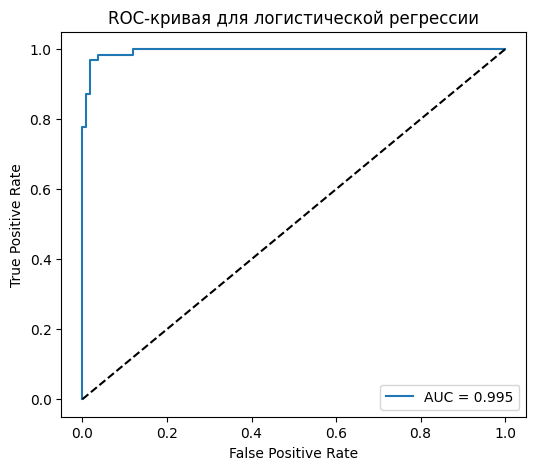

In [84]:
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba_lr):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для логистической регрессии')
plt.legend()
plt.show()

# Влияние коэффициентов

<Figure size 1000x600 with 0 Axes>

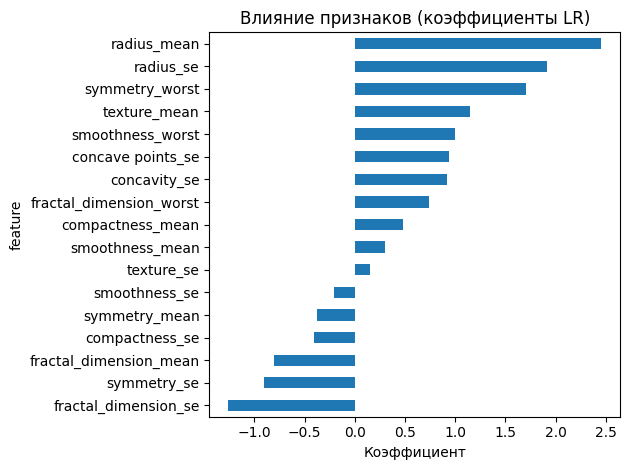

In [85]:
coef_df = pd.DataFrame({'feature': X_lr.columns, 'coef': lr.coef_[0]})
plt.figure(figsize=(10, 6))
coef_df.sort_values('coef').plot.barh(x='feature', y='coef', legend=False)
plt.title('Влияние признаков (коэффициенты LR)')
plt.xlabel('Коэффициент')
plt.tight_layout()
plt.show()

# 4. Настройка регуляризации C на кросс-валидации

In [88]:
lr_cv = LogisticRegressionCV(Cs=10, cv=20, max_iter=1000, random_state=42)
lr_cv.fit(X_train_lr, y_train)
y_pred_cv = lr_cv.predict(X_test_lr)
y_proba_cv = lr_cv.predict_proba(X_test_lr)[:, 1]

print("Accuracy (CV):", accuracy_score(y_test, y_pred_cv))
print("Precision (CV):", precision_score(y_test, y_pred_cv))
print("Recall (CV):", recall_score(y_test, y_pred_cv))
print("F1-score (CV):", f1_score(y_test, y_pred_cv))
print("AUC (CV):", roc_auc_score(y_test, y_proba_cv))

Accuracy (CV): 0.9707602339181286
Precision (CV): 0.953125
Recall (CV): 0.9682539682539683
F1-score (CV): 0.9606299212598425
AUC (CV): 0.9957378012933568


# Влияние коэффициентов после кросс-валидации

<Figure size 1000x600 with 0 Axes>

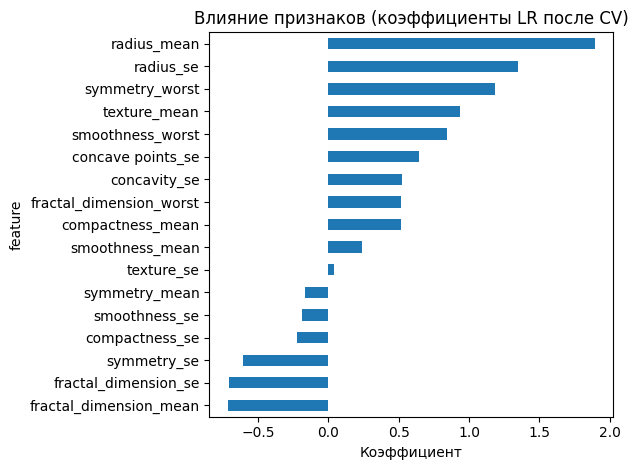

In [89]:
coef_cv_df = pd.DataFrame({'feature': X_lr.columns, 'coef': lr_cv.coef_[0]})
plt.figure(figsize=(10, 6))
coef_cv_df.sort_values('coef').plot.barh(x='feature', y='coef', legend=False)
plt.title('Влияние признаков (коэффициенты LR после CV)')
plt.xlabel('Коэффициент')
plt.tight_layout()
plt.show()

Выводы:

Удаление сильно коррелированных признаков снижает мультиколлинеарность, повышает стабильность коэффициентов и интерпретируемость модели.

Настройка параметра регуляризации C через кросс-валидацию помогает найти компромисс между переобучением и недообучением.

После настройки коэффициенты становятся более стабильными, а качество модели (по метрикам и ROC-AUC) обычно улучшается.

Визуализация коэффициентов показывает, какие признаки сильнее влияют на вероятности классов, что полезно для анализа и принятия решений.